In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import bz2
import pickle
import gensim
from gensim.models import CoherenceModel
from tqdm import tqdm
import pandas as pd
import time
import spacy
import logging
import warnings
warnings.filterwarnings('ignore')
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [3]:
from src.wikipreprocess import WikiPreprocess
from src.lda import LDA

In [4]:
path = 'datapicklesoup.bz2'
with bz2.BZ2File(os.path.join("../data",path), 'rb') as f:
    data = pickle.load(f)
    
df = pd.DataFrame({'text':data[0],'title':data[1]})
#remove low length articles
articlelen=df.text.apply(len)
df=df[articlelen>10]

In [5]:
data = df.text.values
print(f"corpus size: {len(data)}")

corpus size: 49835


## Preprocessing Code

In [6]:
wiki_pp = WikiPreprocess()
print("preprocessing data...")
starttime = time.time()
preprocessed_data =  [wiki_pp.preprocess_document(text=d, min_token_len=4) for d in tqdm(data)]
print('Preprocessing took = {:.0f} minutes'.format((time.time()-starttime)/60.0))

print("creating bigrams...")
data_words_bigrams = wiki_pp.make_bigrams(preprocessed_data)
 
print("lemmatizing data... ")
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# data_lemmatized = [wiki_pp.lemmatize(d, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) for d in tqdm(data_words_bigrams)]

# lemmatizing is computationally intensive so we can save ourselves some time by reading in the data instead
with bz2.BZ2File('../data/lemmatized_bigrams.bz2', 'rb') as f:  #Use datacompression BZ2
    data_lemmatized = pickle.load(f)

preprocessing data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49835/49835 [01:14<00:00, 671.20it/s]


Preprocessing took = 1 minutes
creating bigrams...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49835/49835 [00:09<00:00, 5414.53it/s]


lemmatizing data... 


In [7]:
print("creating dictionary from bigrams...")
id2word_lemmatized = wiki_pp.filtered_dictionary(data_lemmatized, no_below=5, no_above=.1)

print("creating bag of words frequencies...")
corpus_lemmatized = [id2word_lemmatized.doc2bow(text) for text in tqdm(data_lemmatized)]

print(f'Number of unique tokens: {len(id2word_lemmatized)}')
print(f'Number of documents: {len(corpus_lemmatized)}')

creating dictionary from bigrams...
creating bag of words frequencies...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49835/49835 [00:04<00:00, 11210.09it/s]

Number of unique tokens: 42474
Number of documents: 49835


# LDA Collapsed Gibbs Sampler

In [8]:
lda2 = LDA(corpus=corpus_lemmatized, num_topics=20, vocab_len=len(id2word_lemmatized), alpha='asymmetric', beta=0.05)
starttime=time.time()
lda2.fit(burnin=10,max_iter=40)
print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))

starting burn in phase...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [22:44<00:00, 136.44s/it]


running sampler...


  2%|█████▌                                                                                                                                                                                                                        | 1/40 [02:16<1:28:29, 136.13s/it]

iteration: 0 log_likelihood: -39117651.40444927 perplexity: inf


 28%|████████████████████████████████████████████████████████████▊                                                                                                                                                                | 11/40 [24:59<1:05:53, 136.32s/it]

iteration: 10 log_likelihood: -36994052.56196371 perplexity: inf


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 21/40 [47:52<43:17, 136.69s/it]

iteration: 20 log_likelihood: -36477008.164689854 perplexity: inf


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 31/40 [1:11:29<21:22, 142.55s/it]

iteration: 30 log_likelihood: -36273117.374226555 perplexity: inf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [1:32:36<00:00, 138.91s/it]

Time taken = 116 minutes


In [9]:
lda2.print_topics(id2word_lemmatized, topn=20)

0 {'season': 0.012775153176732975, 'game': 0.009650521652480518, 'football': 0.009543484398292642, 'player': 0.009404764116865156, 'club': 0.009014292213587786, 'championship': 0.008749696121235358, 'final': 0.0078206127548846, 'league': 0.007494363204119957, 'finish': 0.006910367945270909, 'compete': 0.006606382143377343, 'match': 0.006513045657725516, 'event': 0.006228754710602519, 'career': 0.005732101851170777, 'represent': 0.005269700913079155, 'win': 0.0051789333215278375, 'third': 0.005166088851025292, 'competition': 0.005088165729976519, 'score': 0.004776473245781425, 'sign': 0.004750784304776335, 'professional': 0.004737083536240288}


1 {'district': 0.008790538943994286, 'village': 0.008404999665573884, 'building': 0.00788315862205536, 'road': 0.006651574815990184, 'town': 0.005949620725734854, 'north': 0.005791900111835599, 'population': 0.00576950767899805, 'county': 0.005543636182549733, 'station': 0.005290504333081792, 'site': 0.005094813941762345, 'central': 0.0050500290

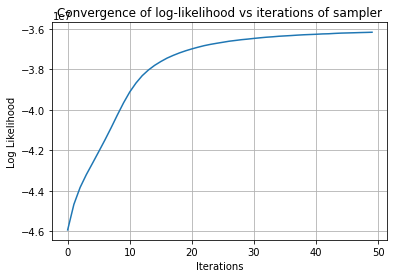

In [10]:
lda2.plot_log_likelihood()

In [11]:
# lda2.plot_perplexity()

In [12]:
pyLDAvis.enable_notebook()
vis_data = lda2.plot_ldavis(id2word_lemmatized)
vis_data

/Users/anthonylimon/Desktop/DSC180B/DSC180B-LDACode/env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anthonylimon/Desktop/DSC180B/DSC180B-LDACode/env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anthonylimon/Desktop/DSC180B/DSC180B-LDACode/env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anthonylimon/Desktop/DSC180B/DSC180B-LDACode/env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for al